# ==============================
# 📌 Project Title: Crime Category Classification
# ==============================

#  Introduction
"""
This project focuses on classifying the type of crime based on historical crime data.
The goal is to develop a machine learning model that can accurately predict the category of a crime
using features such as date, time, location, and district.

Classification models like Random Forest are used to identify hidden patterns
that link specific types of crimes to temporal and spatial factors.
"""


#  Why Crime Classification?
"""
1. Crime prediction plays a crucial role in improving public safety.
2. It helps law enforcement agencies in planning, resource allocation, and preventive actions.
3. Identifying trends and patterns in crimes allows better community awareness and strategic interventions.
4. Crime data is rich, real-world, and suitable for applying data mining and classification techniques.
"""


#  Who Will Benefit From This Project?
"""
- Police departments: for smarter patrol planning and quicker response times.
- Crime analysts: to understand trends, locations, and timings of criminal activities.
- City officials: for safety planning and urban development.
- Security companies: to assess risk levels in different areas.
- Researchers and journalists: for crime-related reports and studies.
"""


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [ ]:
#Information about the data set
print("train Data info ")
train_df.info()
print(train_df.head())
print(train_df.describe())
print(train_df.shape)
print("\ntest Data info ")
test_df.info()
test_df.head()
print(test_df.describe())
test_df.shape

train Data info 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB
                 Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO  

(884262, 7)

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64
---------------------------------------------------------------------------------
2323
Number of duplicates after removal: 0
---------------------------------------------------------------------------------
['Wednesday' 'Tuesday' 'Monday' 'Sunday' 'Saturday' 'Friday' 'Thursday']
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------


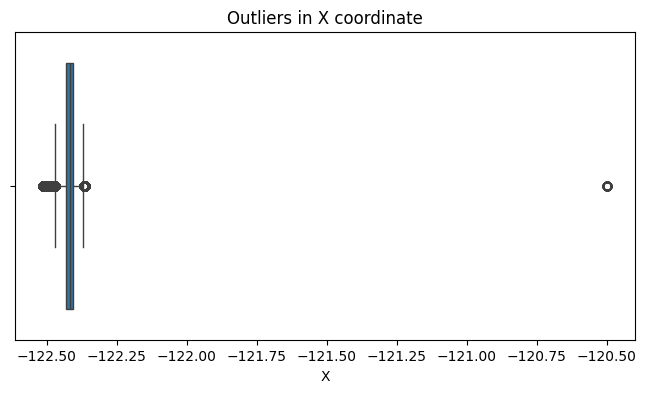

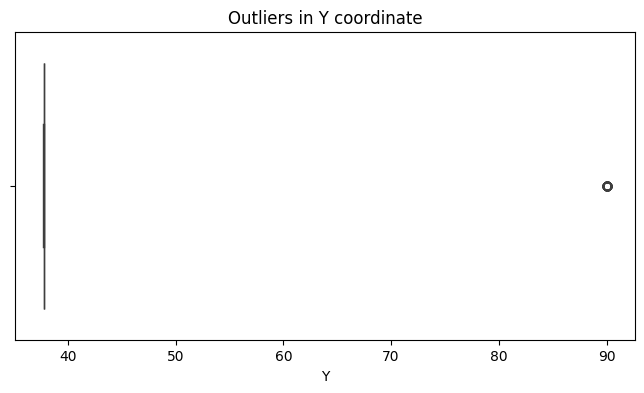

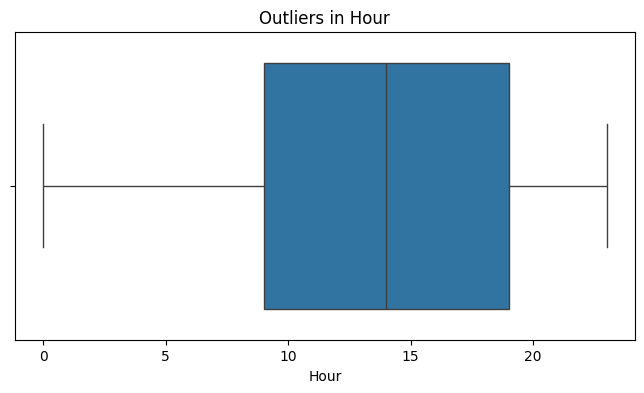

In [ ]:
#Data preprocessing
original_df = train_df.copy()
print(train_df.isnull().sum())
print("---------------------------------------------------------------------------------")
print(train_df.duplicated().sum())
train_df.drop_duplicates(inplace=True)
print("Number of duplicates after removal:", train_df.duplicated().sum())
print("---------------------------------------------------------------------------------")
# Convert 'Dates' to datetime format
# we split dates to can Know which month or hour has the most crimes.
train_df['Dates'] = pd.to_datetime(train_df['Dates'])
print(train_df['DayOfWeek'].unique())
train_df['Year'] = train_df['Dates'].dt.year
train_df['Month'] = train_df['Dates'].dt.month
train_df['Hour'] = train_df['Dates'].dt.hour
train_df['StreetName'] = train_df['Address'].apply(lambda x: x.split(' / ')[0].split(' Block ')[-1])
train_df['IsWeekend'] = train_df['Dates'].dt.dayofweek >= 5  # 0=Monday, 6=Sunday
train_df['IsNight'] = train_df['Hour'].apply(lambda x: x<6 or x>22)
print("---------------------------------------------------------------------------------")
#Remove unseccery columns
train_df = train_df.drop(['Descript', 'Resolution','Address'], axis=1)
print("---------------------------------------------------------------------------------")

# Boxplot for X coordinate
plt.figure(figsize=(8, 4))
sns.boxplot(x=train_df['X'])
plt.title('Outliers in X coordinate')
plt.show()

# Boxplot for Y coordinate
plt.figure(figsize=(8, 4))
sns.boxplot(x=train_df['Y'])
plt.title('Outliers in Y coordinate')
plt.show()

# Boxplot for Hour
plt.figure(figsize=(8, 4))
sns.boxplot(x=train_df['Hour'])
plt.title('Outliers in Hour')
plt.show()


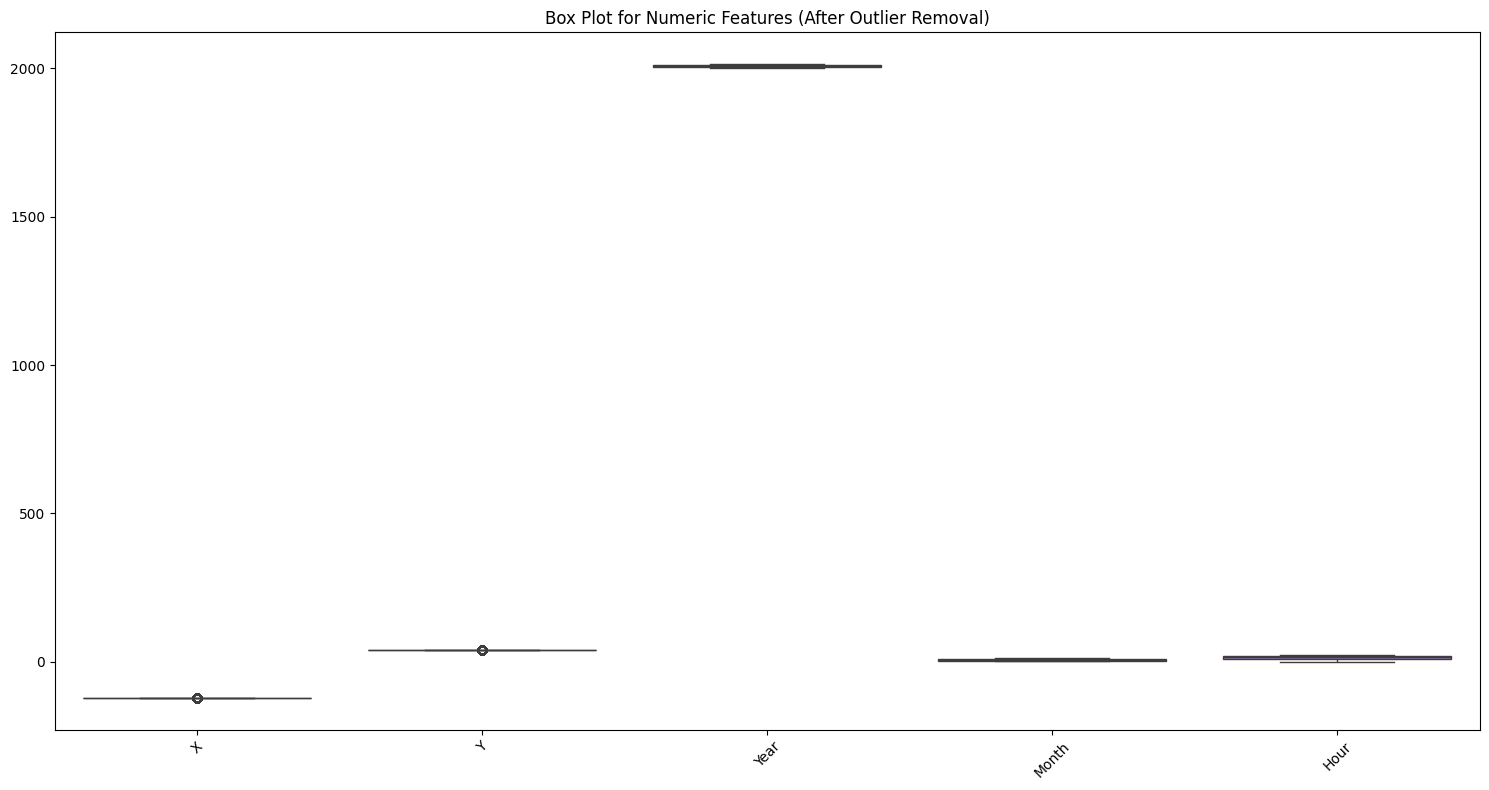

In [ ]:
numeric_columns = train_df.select_dtypes(include=['number']).columns

Q1 = train_df[numeric_columns].quantile(0.25)
Q3 = train_df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = ((train_df[numeric_columns] < (Q1 - 1.5 * IQR)) | (train_df[numeric_columns] > (Q3 + 1.5 * IQR)))
train_df = train_df[~outlier_condition.any(axis=1)]
plt.figure(figsize=(15, 8))

sns.boxplot(data=train_df[numeric_columns])

plt.title("Box Plot for Numeric Features (After Outlier Removal)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Encoded columns: ['Category', 'DayOfWeek', 'PdDistrict', 'StreetName']
Scaled numeric columns: ['DayOfWeek', 'PdDistrict', 'X', 'Y', 'StreetName', 'IsWeekend', 'IsNight']


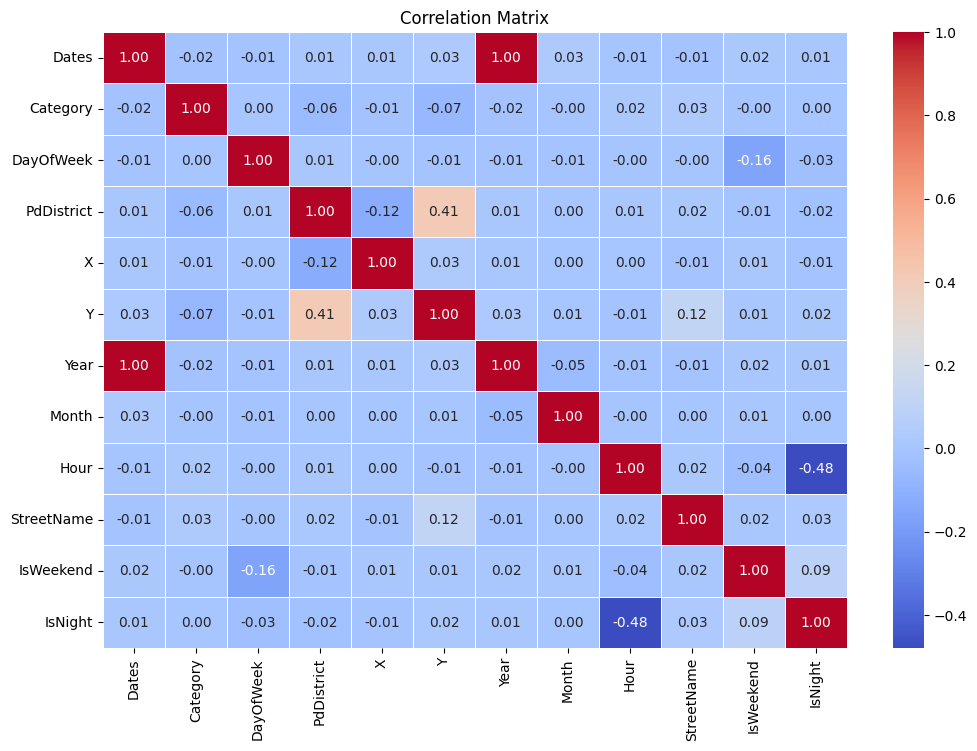

In [ ]:
encoded_df = train_df.copy()

categorical_columns = encoded_df.select_dtypes(include=['object']).columns

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(encoded_df[col])
    label_encoders[col] = le

print("Encoded columns:", list(categorical_columns))
encoded_df['IsWeekend'] = encoded_df['IsWeekend'].astype(int)
encoded_df['IsNight'] = encoded_df['IsNight'].astype(int)
numeric_columns = encoded_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

target_col = 'Category'
if target_col in numeric_columns:
    numeric_columns.remove(target_col)

scaler = StandardScaler()

encoded_df[numeric_columns] = scaler.fit_transform(encoded_df[numeric_columns])

print("Scaled numeric columns:", numeric_columns)

correlation_matrix = encoded_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


#Logestic classification

In [ ]:

df = pd.get_dummies(df, columns=['DayOfWeek', 'PdDistrict'], drop_first=True)

le = LabelEncoder()
df['Category_encoded'] = le.fit_transform(df['Category'])

street_encoder = LabelEncoder()
df['StreetName'] = street_encoder.fit_transform(df['StreetName'])

df.drop(columns=['Dates', 'Descript', 'Resolution', 'Address', 'Category'], inplace=True)

df = df.sample(n=20000, random_state=42)

X = df.drop('Category_encoded', axis=1)
y = df['Category_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000, solver='saga', multi_class='multinomial', class_weight='balanced')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=2))
print("✅ Overall Accuracy:", round(accuracy_score(y_test, y_pred), 2))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


📊 Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00       354
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.05      0.02      0.03       167
           5       0.00      0.07      0.01        15
           6       0.01      0.25      0.01         8
           7       0.29      0.17      0.21       252
           8       0.02      0.10      0.03        21
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         2
          12       0.02      0.06      0.03        51
          13       0.09      0.05      0.07        73
          14       0.00      0.00      0.00         1
          15       0.00      0.17      0.01        12
          16       0.30      0.05      0.08       788
 

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use

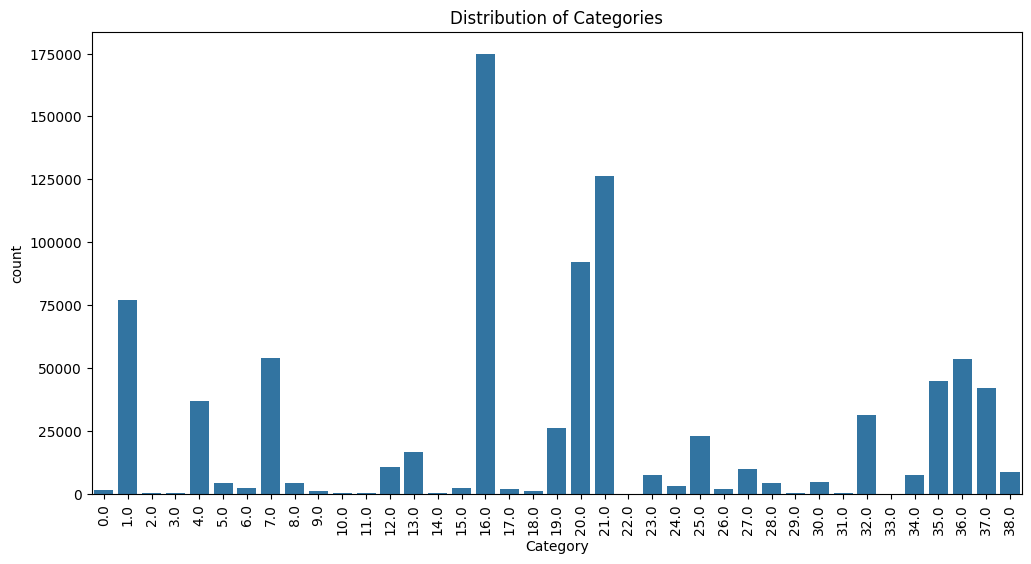

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Category', data=train_df)
plt.xticks(rotation=90)
plt.title('Distribution of Categories')
plt.show()

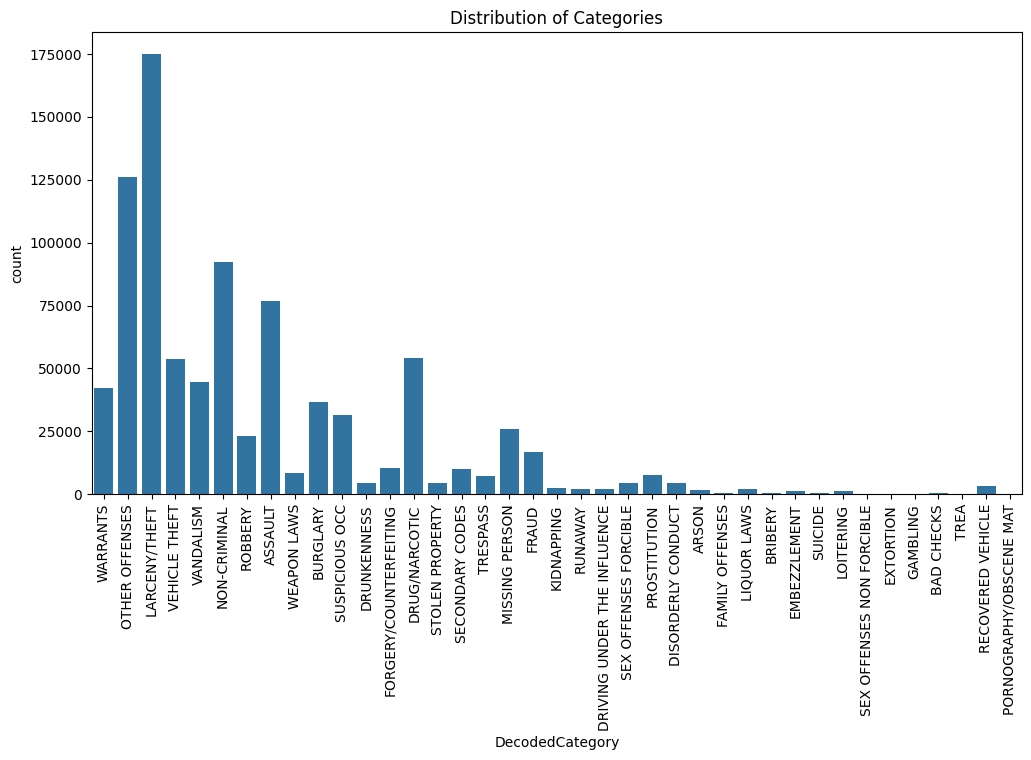

In [ ]:
train_df['DecodedCategory'] = label_encoders['Category'].inverse_transform(train_df['Category'])

plt.figure(figsize=(12, 6))
sns.countplot(x='DecodedCategory', data=train_df)
plt.xticks(rotation=90)
plt.title('Distribution of Categories')
plt.show()


#RandomForest

In [ ]:

categorical_cols = ['DayOfWeek', 'PdDistrict', 'StreetName', 'Category']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df.drop(columns=['Category'])
y = df['Category']

df_sample = df.sample(n=20000, random_state=42)
X = df_sample.drop(columns=['Category'])
y = df_sample['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, digits=2))
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.16      0.13      0.14       354
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.17      0.05      0.07       167
           5       0.00      0.00      0.00        15
           6       0.00      0.00      0.00         8
           7       0.30      0.35      0.32       252
           8       0.00      0.00      0.00        21
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         2
          12       0.17      0.02      0.04        51
          13       0.00      0.00      0.00        73
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00        12
          16       0.28      0.68      0.39       788
  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#RandomForest by using smote

In [ ]:

numeric_columns = train_df.select_dtypes(include=['number']).columns

Q1 = train_df[numeric_columns].quantile(0.25)
Q3 = train_df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = ((train_df[numeric_columns] < (Q1 - 1.5 * IQR)) | (train_df[numeric_columns] > (Q3 + 1.5 * IQR)))
train_df = train_df[~outlier_condition.any(axis=1)]

categorical_columns = train_df.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    label_encoders[col] = le

train_df = pd.get_dummies(train_df, columns=['PdDistrict', 'DayOfWeek'], drop_first=True)

X = train_df.drop('Category', axis=1)
y = train_df['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=4,k_neighbors=3 )
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {X_train.shape}")
print(f"After SMOTE: {X_train_smote.shape}")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1,
    warm_start=True
)

rf_model.fit(X_train_smote, y_train_smote)

y_pred = rf_model.predict(X_test)
print(" Classification Report:")
print(classification_report(y_test, y_pred, digits=2))
print(f" Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")


Missing values:
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
Year          0
Month         0
Day           0
Hour          0
IsWeekend     0
dtype: int64

Duplicated rows: 4658
Before SMOTE: (650673, 25)
After SMOTE: (5060874, 25)
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.80      0.25       277
           1       0.88      0.52      0.65     14397
           2       0.54      0.84      0.66        75
           3       0.02      0.40      0.04        55
           4       0.75      0.93      0.83      6649
           5       0.34      0.48      0.40       828
           6       0.27      0.90      0.41       398
           7       0.77      0.87      0.81     10520
           8       0.84      0.98      0.90       806
           9       0.14      0.72      0.23       216
          10       0.05      0.18      0.08        44
          11

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


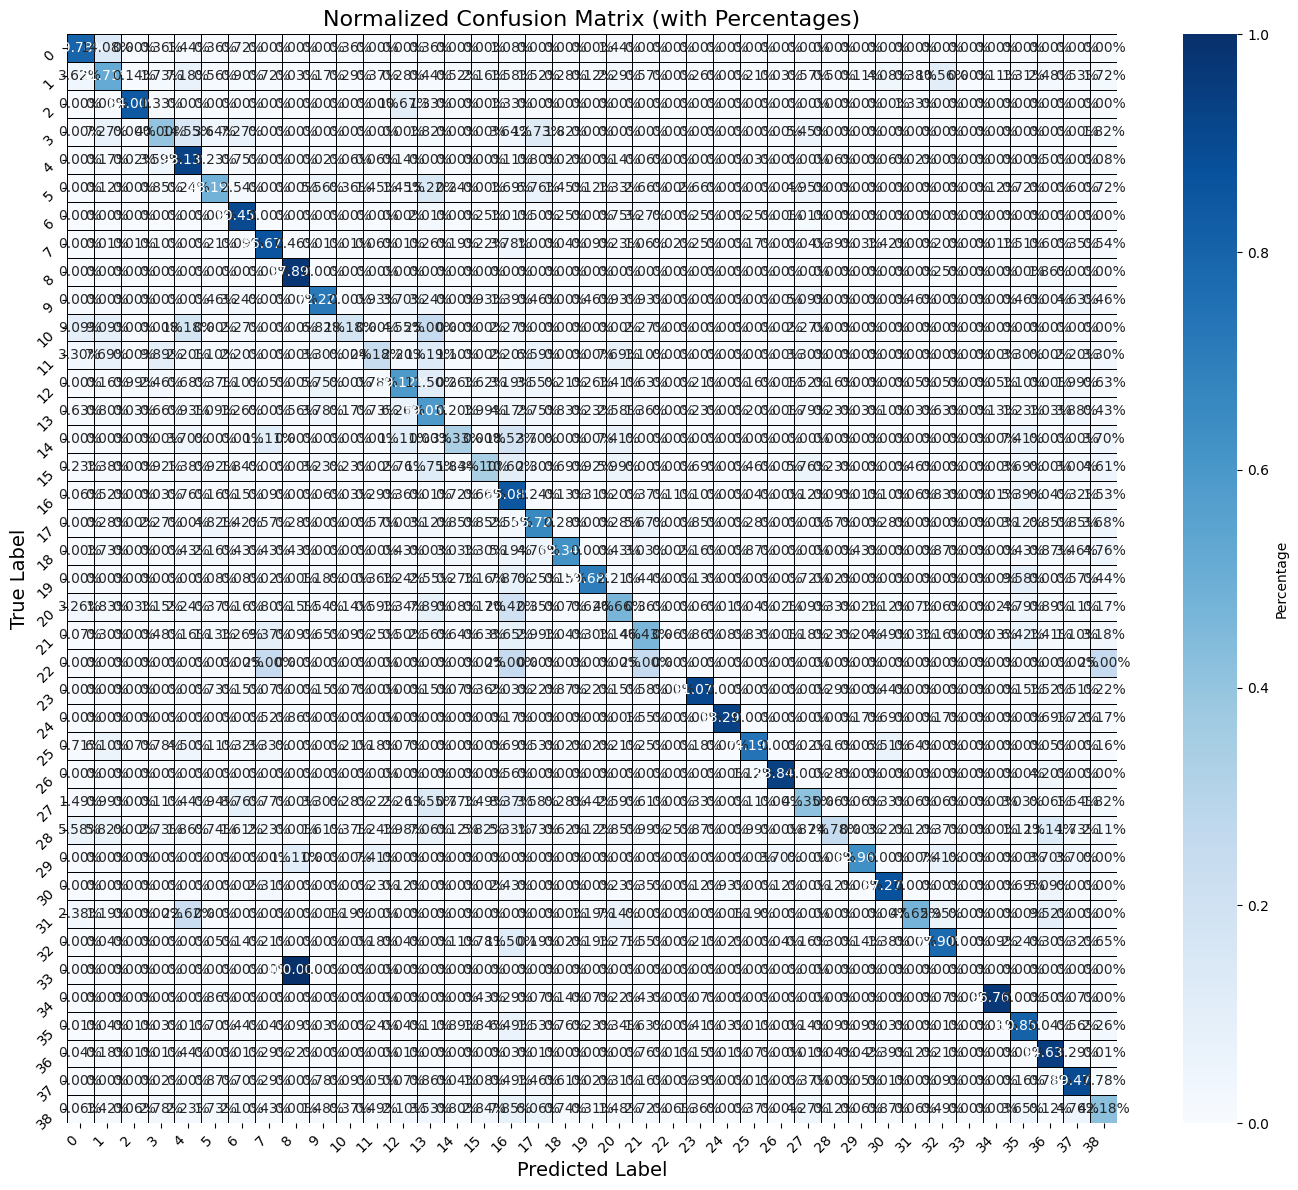

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap="Blues",
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_,
            linewidths=0.5, linecolor='black', cbar=True, cbar_kws={'label': 'Percentage'})  # إضافة شريط الألوان

plt.title("Normalized Confusion Matrix (with Percentages)", fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45, va="top")
plt.tight_layout()

# عرض الرسم
plt.show()


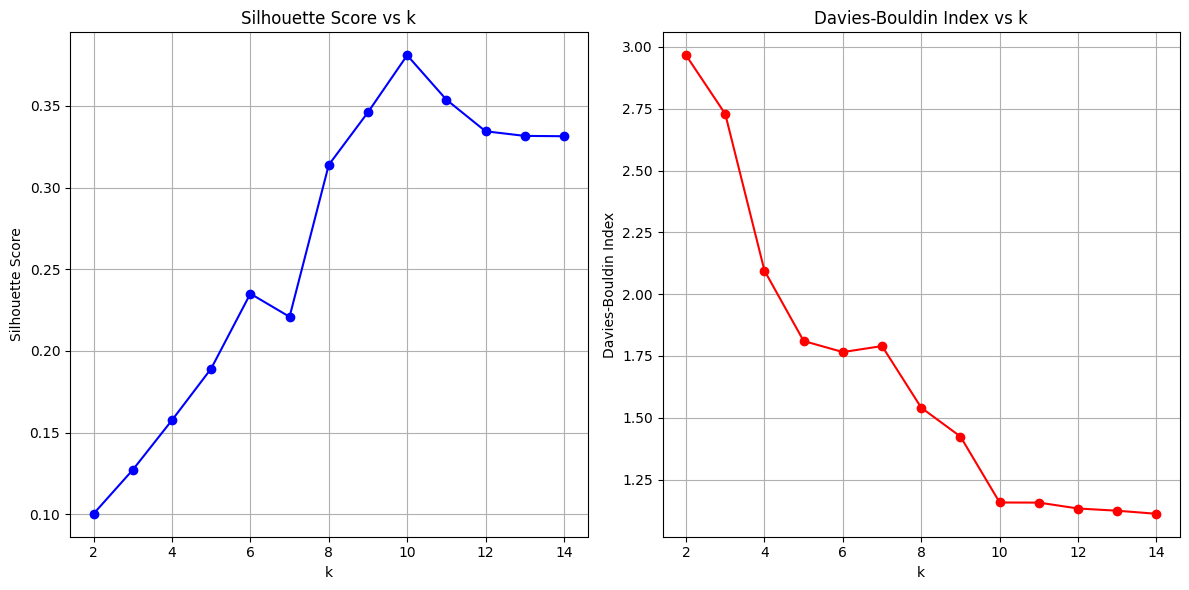

أفضل قيمة لـ k بناءً على Silhouette Score: 10
أفضل قيمة لـ k بناءً على Davies-Bouldin Index: 14


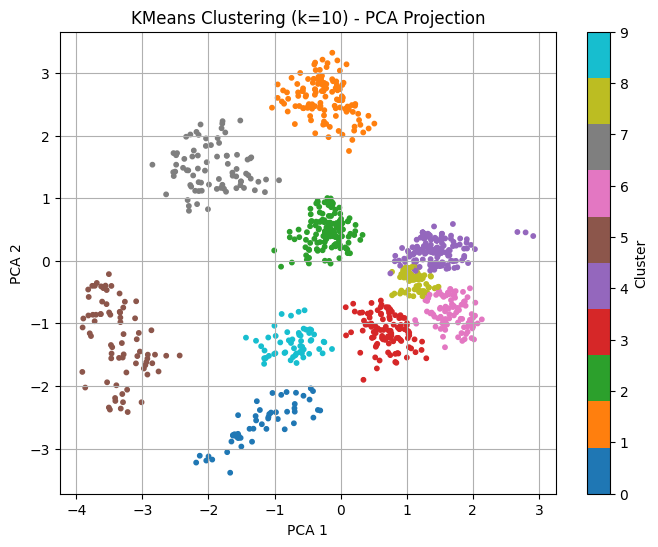

In [ ]:

features = ['X', 'Y', 'Hour', 'Year', 'Month', 'DayOfWeek', 'IsWeekend', 'IsNight', 'PdDistrict']
X = train_df[features].copy()

X = pd.get_dummies(X, columns=['DayOfWeek', 'PdDistrict'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sil_scores = []
db_scores = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)

    sil_score = silhouette_score(X_scaled, clusters)
    sil_scores.append(sil_score)

    db_score = davies_bouldin_score(X_scaled, clusters)
    db_scores.append(db_score)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_range, sil_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score vs k')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, db_scores, marker='o', linestyle='-', color='r')
plt.title('Davies-Bouldin Index vs k')
plt.xlabel('k')
plt.ylabel('Davies-Bouldin Index')
plt.grid(True)

plt.tight_layout()
plt.show()

best_k_silhouette = k_range[np.argmax(sil_scores)]
best_k_db = k_range[np.argmin(db_scores)]

print(f'أفضل قيمة لـ k بناءً على Silhouette Score: {best_k_silhouette}')
print(f'أفضل قيمة لـ k بناءً على Davies-Bouldin Index: {best_k_db}')


best_k = best_k_silhouette
kmeans_best = KMeans(n_clusters=best_k, random_state=42)
clusters_best = kmeans_best.fit_predict(X_scaled)

train_df['Cluster'] = clusters_best

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_best, cmap='tab10', s=10)
plt.title(f'KMeans Clustering (k={best_k}) - PCA Projection')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


عدد العناقيد (k=30)
Silhouette Score: 0.5178
Davies-Bouldin Index: 0.8492
--------------------------------------------------
عدد العناقيد (k=31)
Silhouette Score: 0.5367
Davies-Bouldin Index: 0.7473
--------------------------------------------------
عدد العناقيد (k=32)
Silhouette Score: 0.5190
Davies-Bouldin Index: 0.9640
--------------------------------------------------
عدد العناقيد (k=33)
Silhouette Score: 0.5506
Davies-Bouldin Index: 0.8760
--------------------------------------------------
عدد العناقيد (k=34)
Silhouette Score: 0.5840
Davies-Bouldin Index: 0.7401
--------------------------------------------------
عدد العناقيد (k=35)
Silhouette Score: 0.5726
Davies-Bouldin Index: 0.8097
--------------------------------------------------
عدد العناقيد (k=36)
Silhouette Score: 0.6018
Davies-Bouldin Index: 0.7691
--------------------------------------------------
عدد العناقيد (k=37)
Silhouette Score: 0.5899
Davies-Bouldin Index: 0.8176
--------------------------------------------------


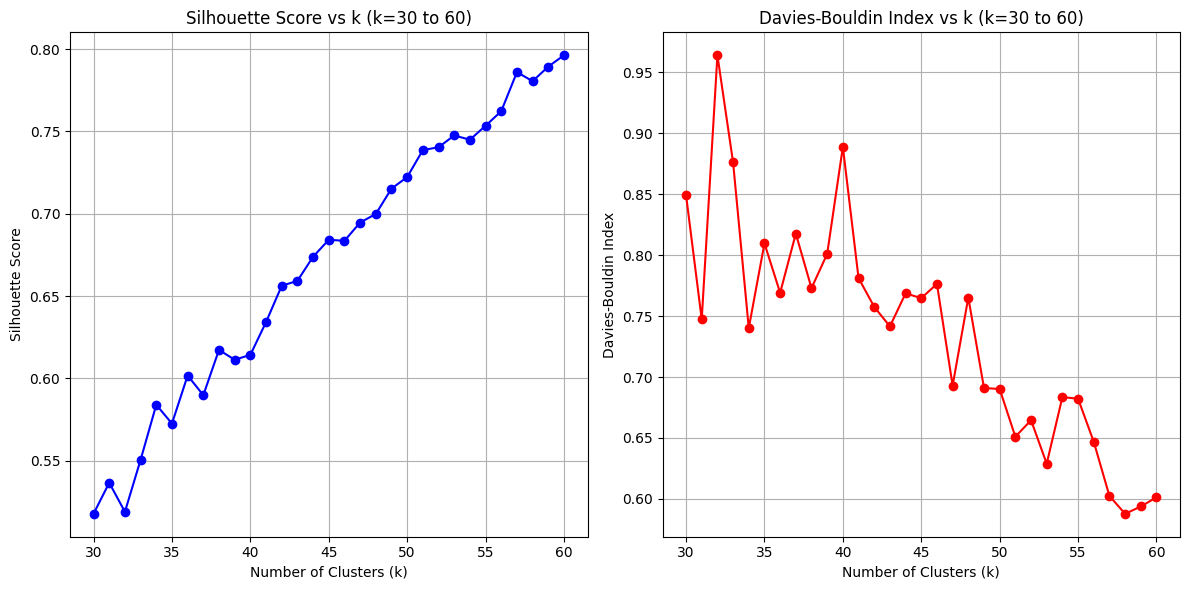

أفضل قيمة لـ k بناءً على Silhouette Score: 60
أفضل قيمة لـ k بناءً على Davies-Bouldin Index: 58


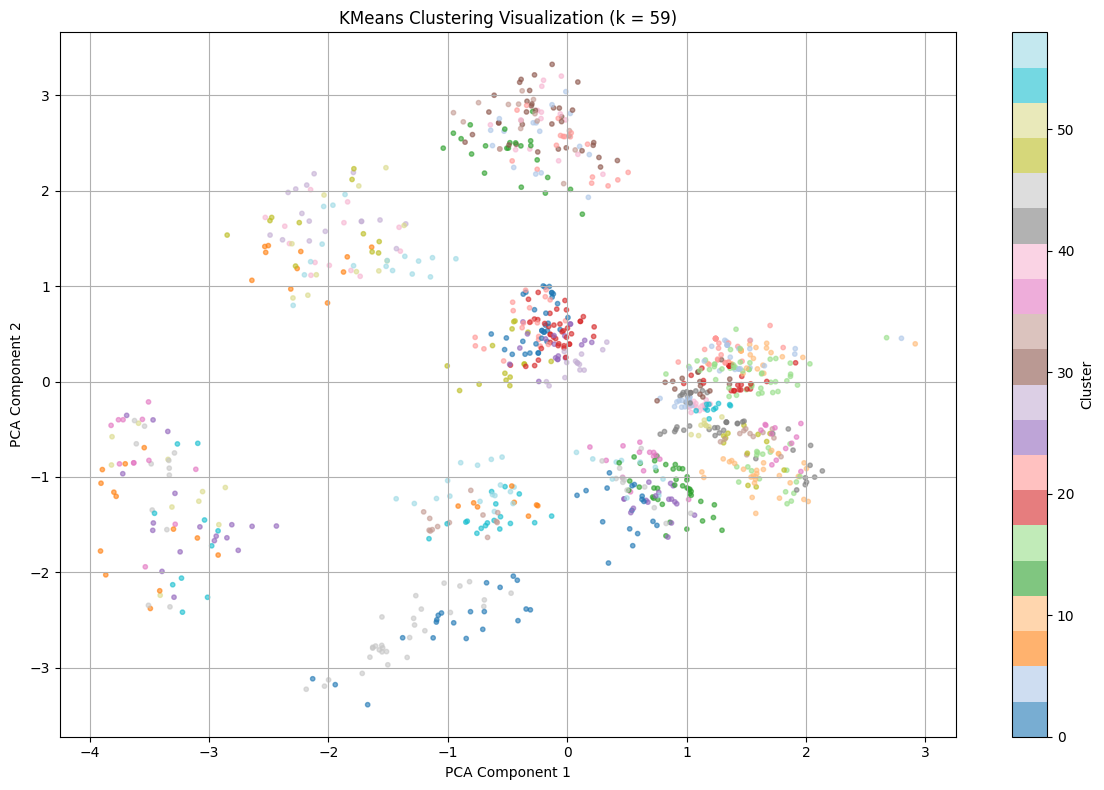

In [ ]:

features = ['X', 'Y', 'Hour', 'Year', 'Month', 'DayOfWeek', 'IsWeekend', 'IsNight', 'PdDistrict']
X = train_df[features].copy()

X = pd.get_dummies(X, columns=['DayOfWeek', 'PdDistrict'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sil_scores = []
db_scores = []
k_range = range(30, 61)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, clusters)
    db = davies_bouldin_score(X_scaled, clusters)
    sil_scores.append(sil)
    db_scores.append(db)

    print(f'عدد العناقيد (k={k})')
    print(f'Silhouette Score: {sil:.4f}')
    print(f'Davies-Bouldin Index: {db:.4f}')
    print('-' * 50)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_range, sil_scores, marker='o', linestyle='-', color='blue')
plt.title('Silhouette Score vs k (k=30 to 60)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, db_scores, marker='o', linestyle='-', color='red')
plt.title('Davies-Bouldin Index vs k (k=30 to 60)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.grid(True)

plt.tight_layout()
plt.show()

best_k_silhouette = k_range[np.argmax(sil_scores)]
best_k_db = k_range[np.argmin(db_scores)]

print(f'أفضل قيمة لـ k بناءً على Silhouette Score: {best_k_silhouette}')
print(f'أفضل قيمة لـ k بناءً على Davies-Bouldin Index: {best_k_db}')

best_k = 59
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
clusters_final = kmeans_final.fit_predict(X_scaled)

train_df['Cluster'] = clusters_final

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_final, cmap='tab20', s=10, alpha=0.6)
plt.title(f'KMeans Clustering Visualization (k = {best_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


عدد العناقيد (k=45)
Silhouette Score: 0.68
Davies-Bouldin Score: 0.75
--------------------------------------------------


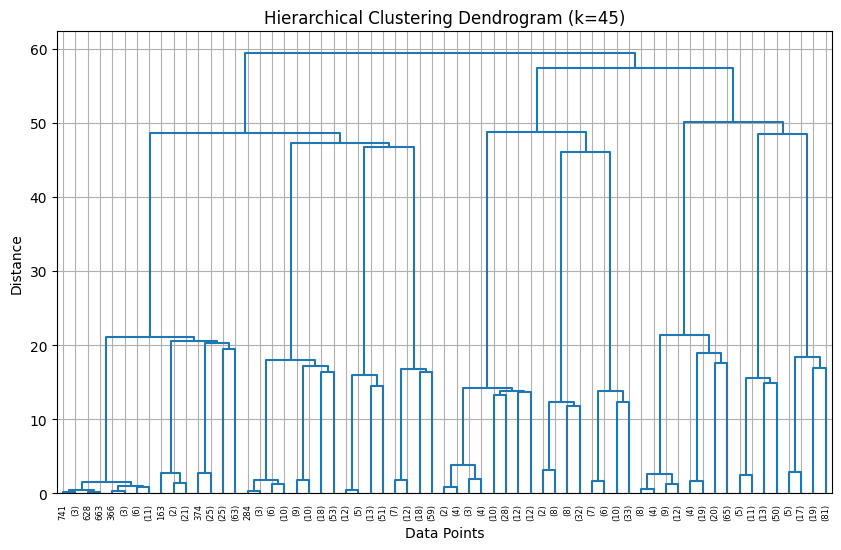

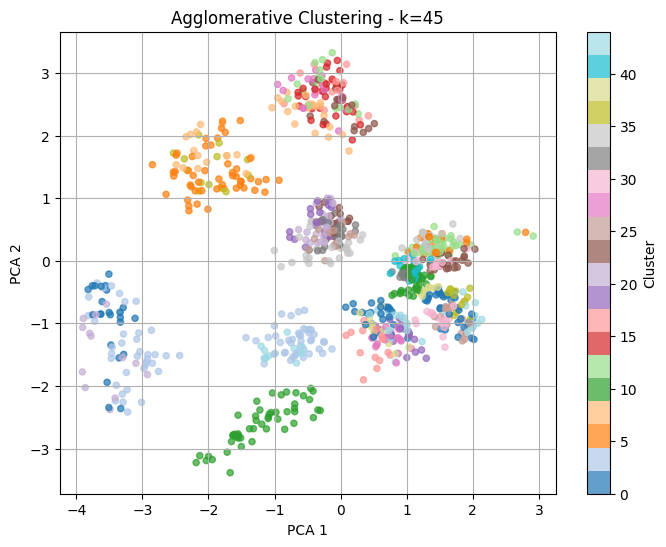

عدد العناقيد (k=46)
Silhouette Score: 0.69
Davies-Bouldin Score: 0.73
--------------------------------------------------


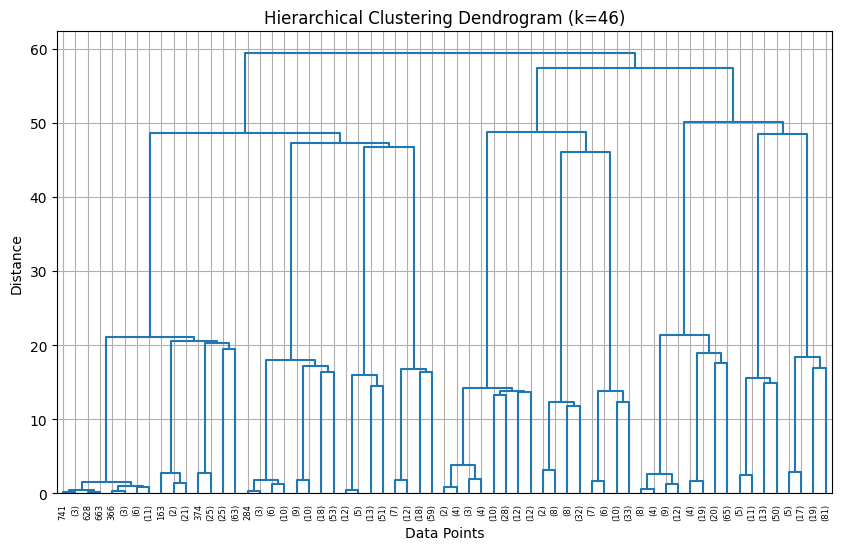

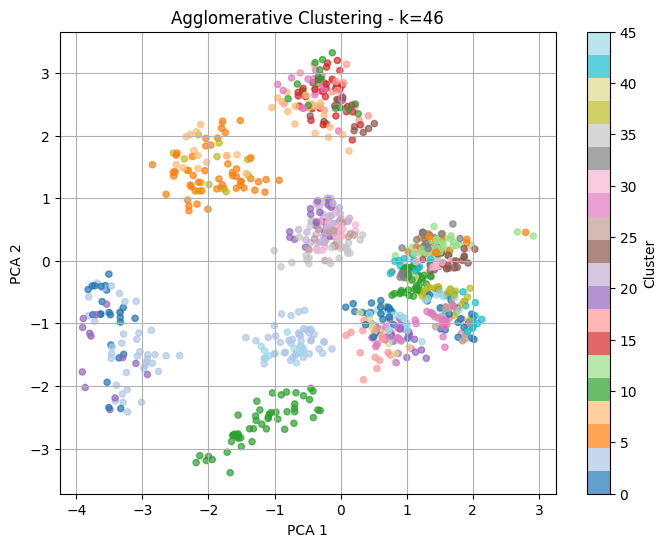

عدد العناقيد (k=47)
Silhouette Score: 0.70
Davies-Bouldin Score: 0.70
--------------------------------------------------


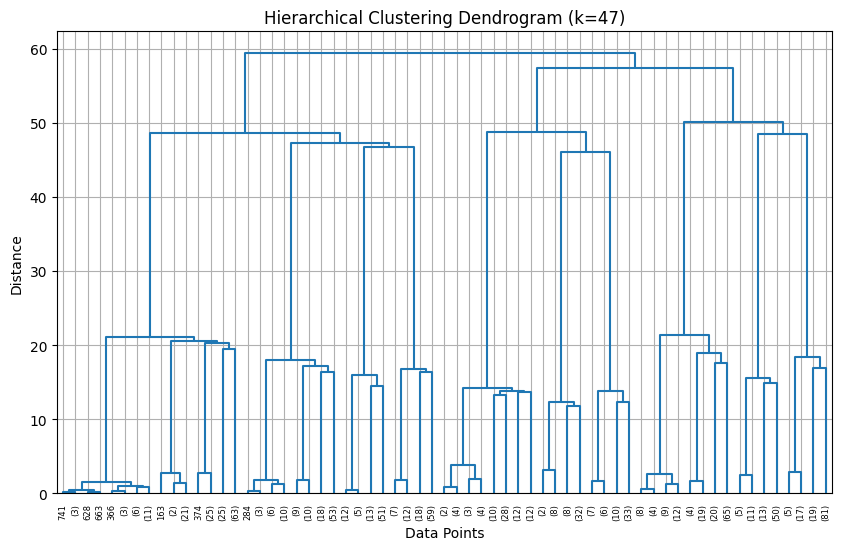

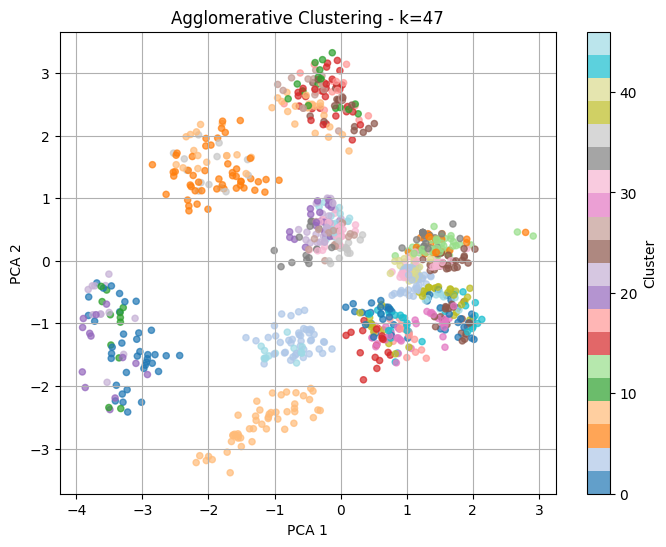

عدد العناقيد (k=48)
Silhouette Score: 0.71
Davies-Bouldin Score: 0.67
--------------------------------------------------


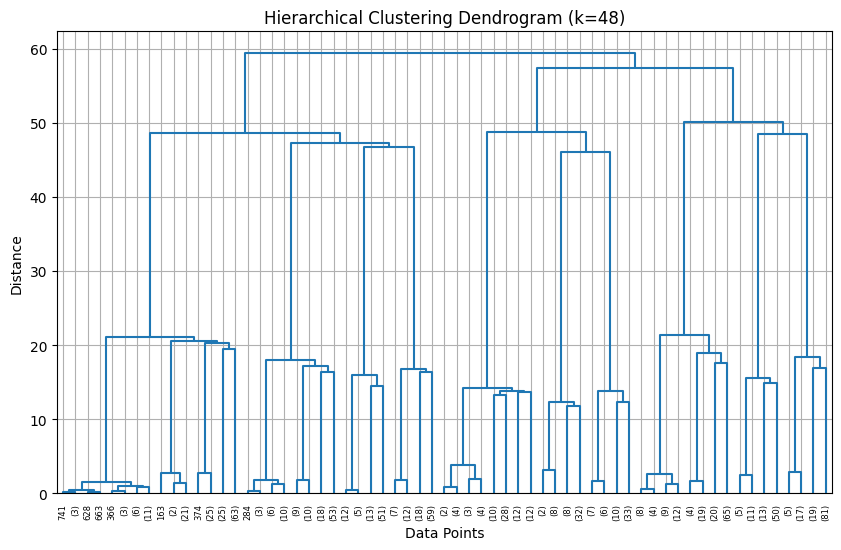

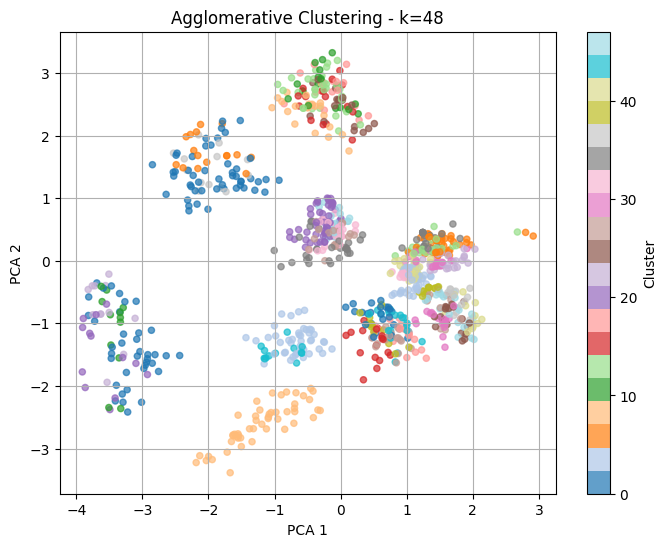

عدد العناقيد (k=49)
Silhouette Score: 0.72
Davies-Bouldin Score: 0.64
--------------------------------------------------


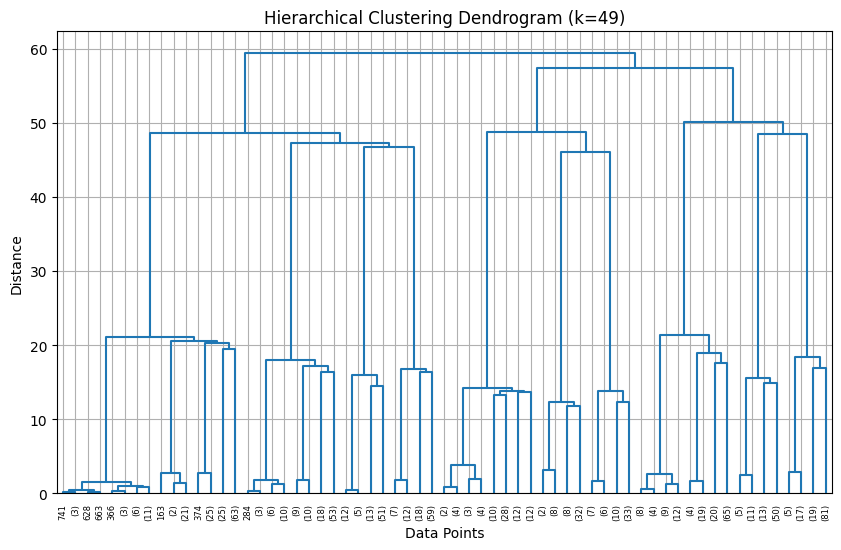

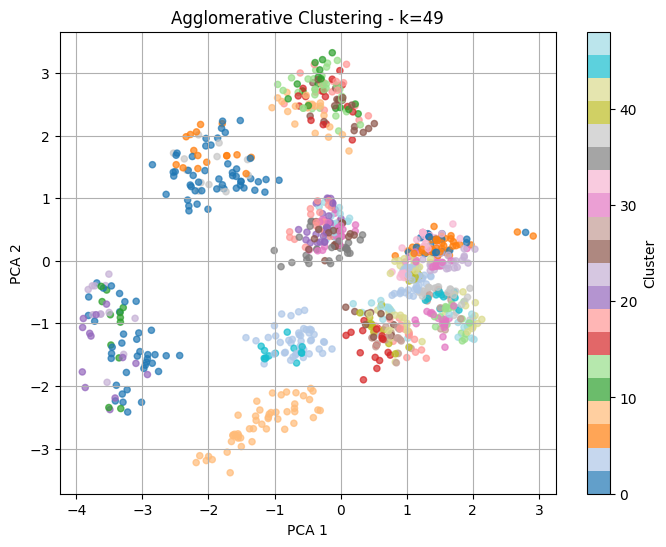

عدد العناقيد (k=50)
Silhouette Score: 0.73
Davies-Bouldin Score: 0.64
--------------------------------------------------


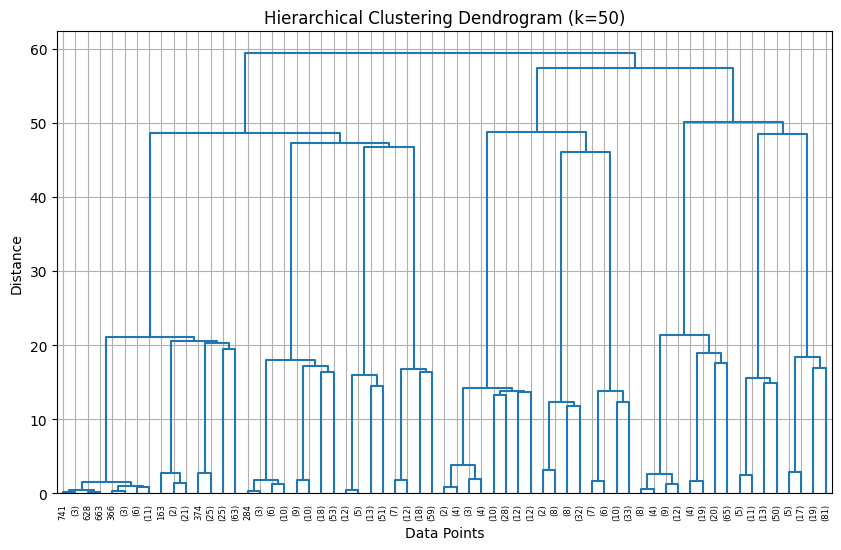

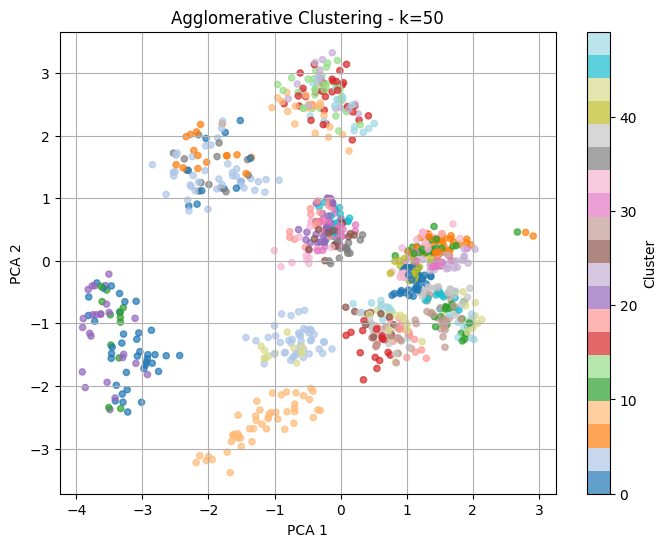

عدد العناقيد (k=51)
Silhouette Score: 0.73
Davies-Bouldin Score: 0.64
--------------------------------------------------


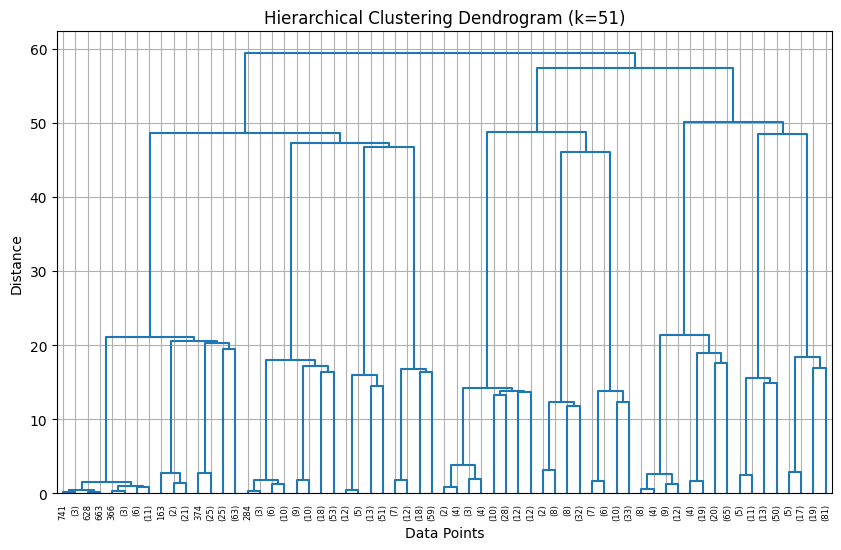

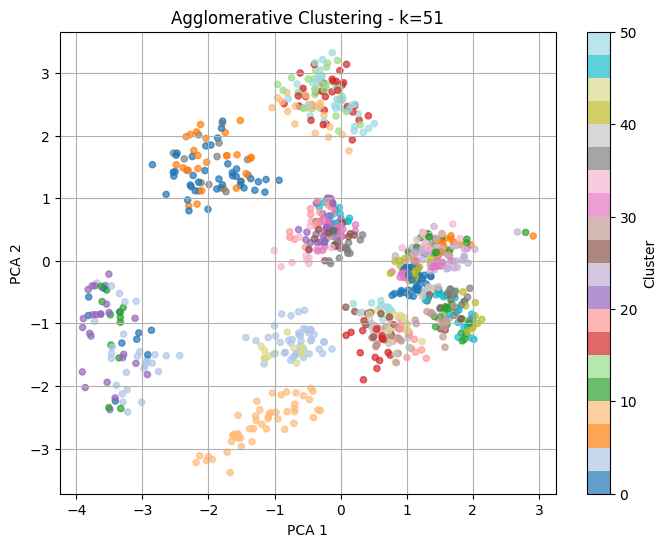

عدد العناقيد (k=52)
Silhouette Score: 0.74
Davies-Bouldin Score: 0.63
--------------------------------------------------


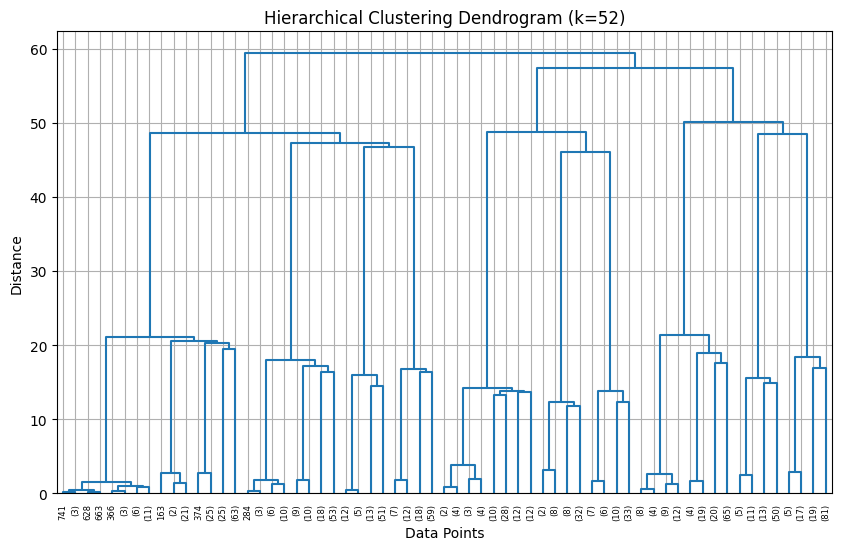

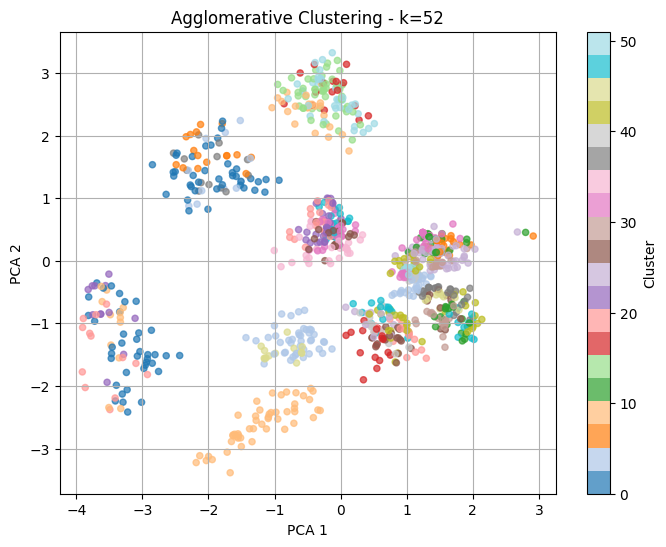

عدد العناقيد (k=53)
Silhouette Score: 0.75
Davies-Bouldin Score: 0.63
--------------------------------------------------


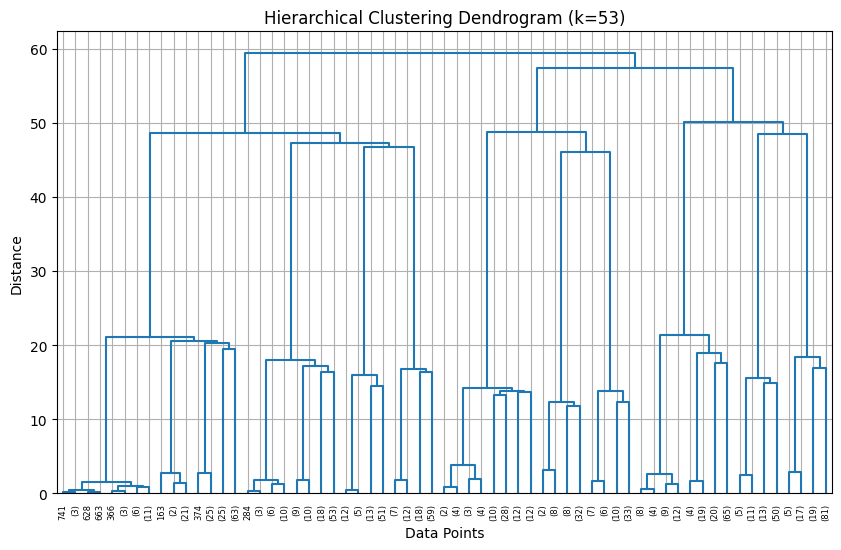

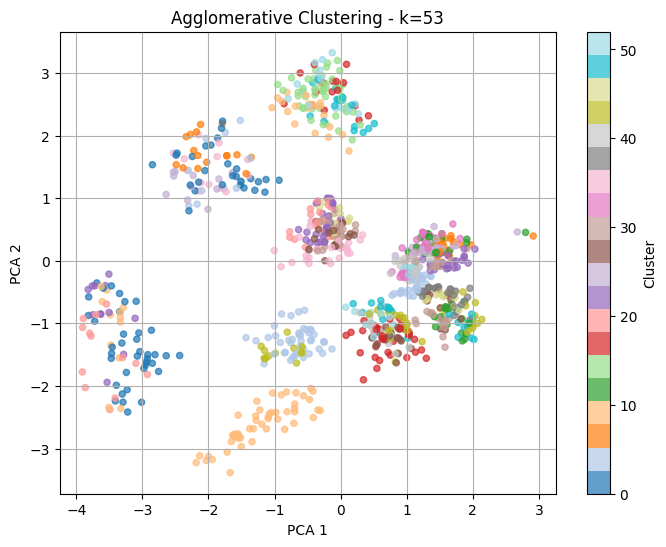

عدد العناقيد (k=54)
Silhouette Score: 0.76
Davies-Bouldin Score: 0.61
--------------------------------------------------


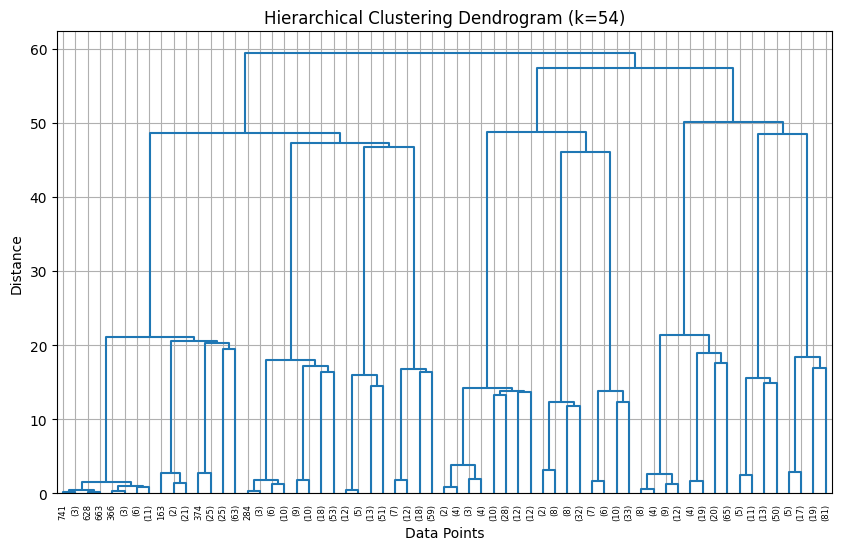

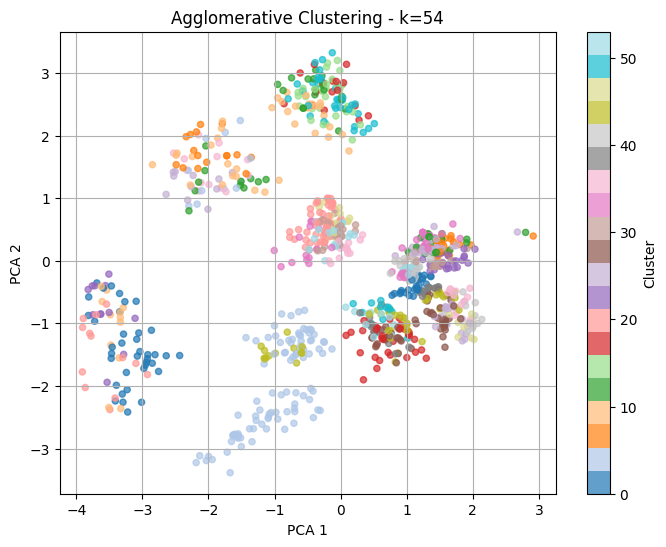

عدد العناقيد (k=55)
Silhouette Score: 0.77
Davies-Bouldin Score: 0.60
--------------------------------------------------


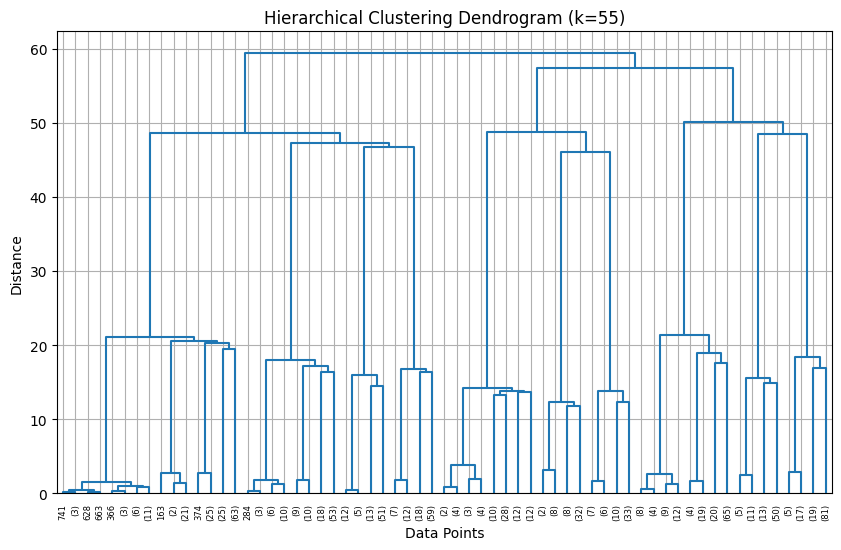

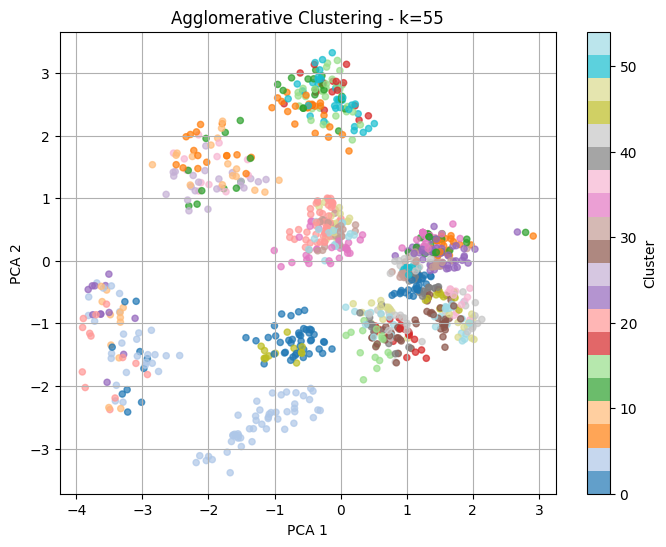

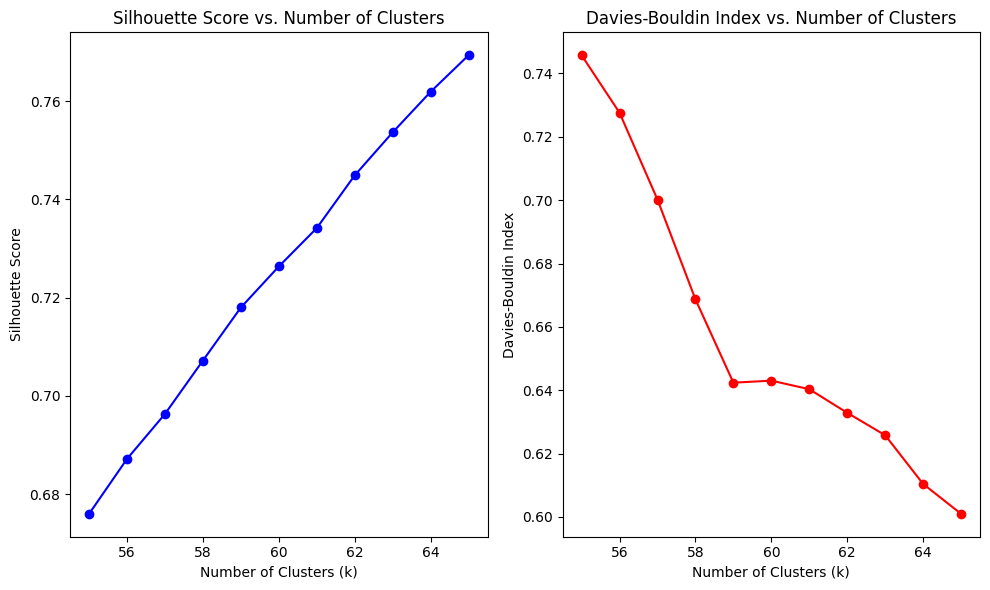

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sil_scores = []
db_scores = []
X_pca = PCA(n_components=2).fit_transform(X_scaled)

for k in range(45, 56):
    agglo = AgglomerativeClustering(n_clusters=k)
    clusters_agglo = agglo.fit_predict(X_scaled)

    sil_score = silhouette_score(X_scaled, clusters_agglo)
    db_score = davies_bouldin_score(X_scaled, clusters_agglo)
    sil_scores.append(sil_score)
    db_scores.append(db_score)

    print(f"عدد العناقيد (k={k})")
    print(f"Silhouette Score: {sil_score:.2f}")
    print(f"Davies-Bouldin Score: {db_score:.2f}")
    print("-" * 50)

    linked = linkage(X_scaled, method='ward')

    plt.figure(figsize=(10, 6))
    dendrogram(linked, truncate_mode='level', p=5, color_threshold=0)
    plt.title(f'Hierarchical Clustering Dendrogram (k={k})')
    plt.xlabel('Data Points')
    plt.ylabel('Distance')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_agglo, cmap='tab20', s=20, alpha=0.7)
    plt.title(f'Agglomerative Clustering - k={k}')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.show()

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(range(55, 66), sil_scores, marker='o', color='b')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.subplot(1, 2, 2)
plt.plot(range(45, 56), db_scores, marker='o', color='r')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()


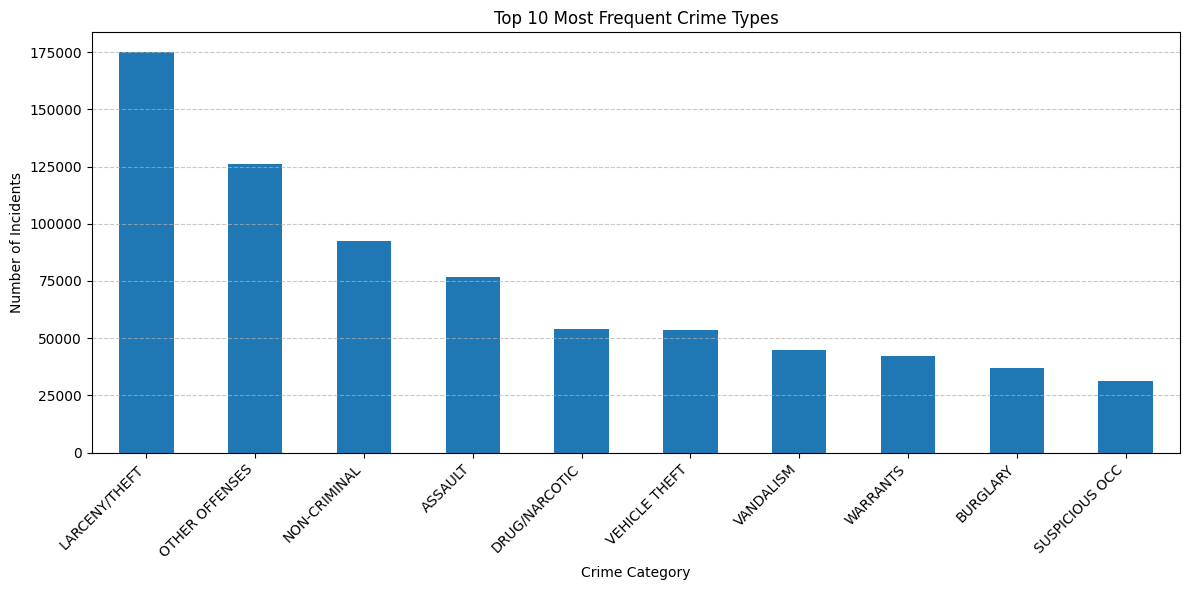

In [ ]:
plt.figure(figsize=(12,6))
original_df['Category'].value_counts().head(10).plot(kind='bar', color='#1f77b4')
plt.title('Top 10 Most Frequent Crime Types')
plt.xlabel('Crime Category')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

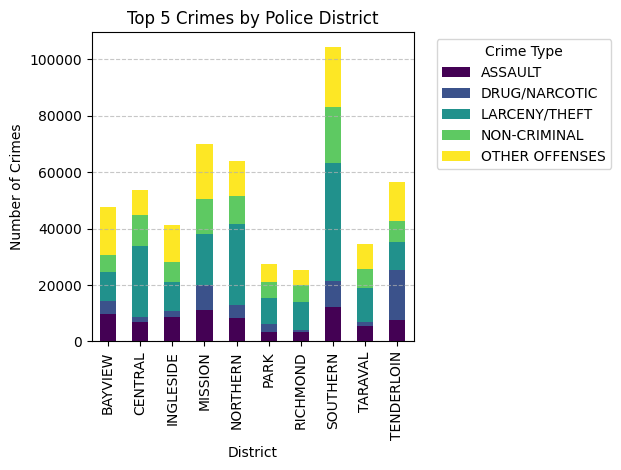

In [ ]:
top_crimes = original_df['Category'].value_counts().head(5).index
district_data = original_df[original_df['Category'].isin(top_crimes)].groupby(
    ['PdDistrict', 'Category']).size().unstack()

plt.figure(figsize=(12,6))
district_data.plot(kind='bar', stacked=True, cmap='viridis')
plt.title('Top 5 Crimes by Police District')
plt.xlabel('District')
plt.ylabel('Number of Crimes')
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


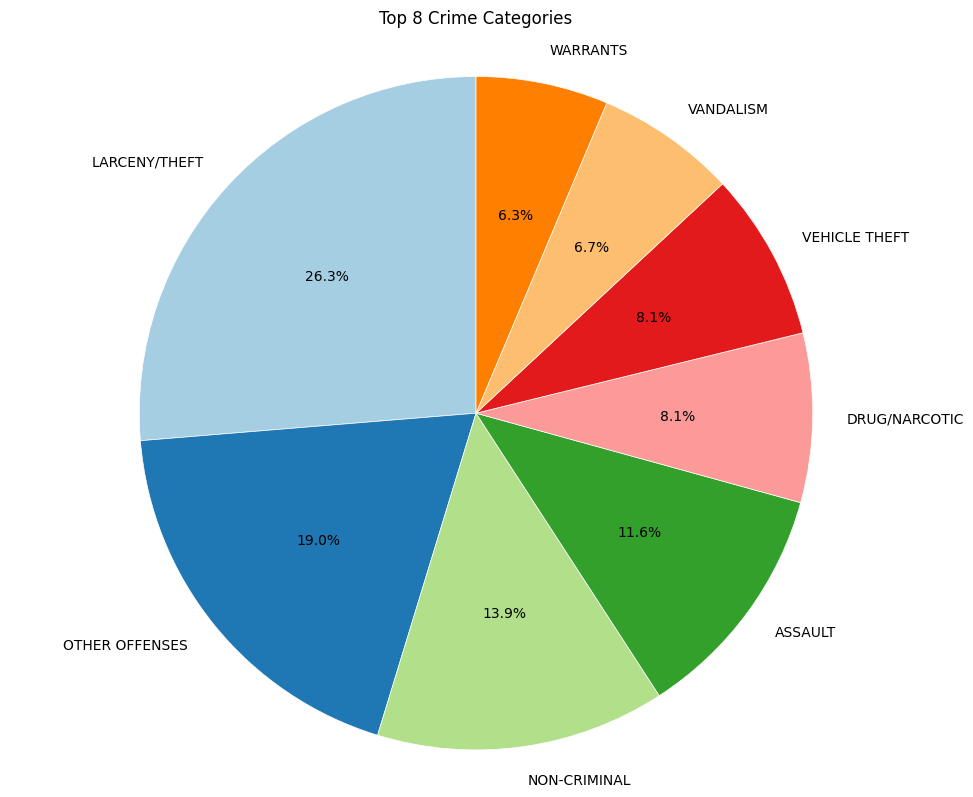

In [ ]:
top_crimes = original_df['Category'].value_counts().nlargest(8)

labels = top_crimes.index.tolist()
sizes = top_crimes.values.tolist()

# Create plot
plt.figure(figsize=(10, 8))
plt.pie(sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.Paired.colors,
        wedgeprops={'edgecolor': 'white', 'linewidth': 0.5})

plt.title('Top 8 Crime Categories', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()